In [19]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split    
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from concurrent.futures import ThreadPoolExecutor, as_completed
from scipy.spatial.distance import minkowski
from sklearn.metrics import  confusion_matrix,precision_score,recall_score,f1_score

In [20]:
def to_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [21]:
def get_nblocks(arr, tile_size=4):
    r, c = arr.shape
    tilings = []

    for i in range(0, r, tile_size):
        for j in range(0, c, tile_size):
            tiling = arr[i:i + tile_size, j:j + tile_size]
            tilings.append(tiling)

    return np.array(tilings)

In [22]:
def get_block_meansvars(arr):
    means_vars = []
    for block in arr:
        means_vars.append([np.mean(block), np.var(block)])
    return np.array(means_vars)


In [23]:
def get_img_features(img):
    blocks = get_nblocks(img)
    return get_block_meansvars(blocks)


In [24]:
def extract_features(filepath, label):
    img = cv2.imread(filepath)
    gray_img = to_gray(img)
    features = get_img_features(gray_img)
    return features, label


In [25]:
def load_imgs_from_directory(directory, label, num_images=None):
    images = []
    labels = []
    files = os.listdir(directory)
    if num_images is not None:
        files = files[:num_images]
    with ThreadPoolExecutor(max_workers=8) as executor:
        temp = [executor.submit(extract_features, os.path.join(directory, filename), label) for filename
                   in files]
        
        for i in as_completed(temp):
            features, lbl = i.result()
            images.append(features)
            labels.append(lbl)
    return images, labels

In [26]:
train_fake='E:\zipp\college\Third Year\\5th Sem\ML\ML\Lab 3\\train\FAKE'
train_real='E:\zipp\college\Third Year\\5th Sem\ML\ML\Lab 3\\train\REAL'
num_images = 10000

In [27]:
fake_images, fake_labels = load_imgs_from_directory(train_fake, 0, num_images=num_images)
real_images, real_labels = load_imgs_from_directory(train_real, 1, num_images=num_images)

In [28]:
fake_images_mean , fake_images_var = [], []
for j in range(len(fake_images[0])):
    temp1, temp2 = [], []
    for i in range(num_images):
        temp1.append(fake_images[i][j][0])
        temp2.append(fake_images[i][j][1])
    fake_images_mean.append(temp1)
    fake_images_var.append(temp2)
fake_images_mean = np.array(fake_images_mean)
fake_images_var = np.array(fake_images_var)

real_images_mean , real_images_var = [], []
for j in range(len(fake_images[0])):
    temp1, temp2 = [], []
    for i in range(num_images):
        temp1.append(real_images[i][j][0])
        temp2.append(real_images[i][j][1])
    real_images_mean.append(temp1)
    real_images_var.append(temp2)
real_images_mean = np.array(real_images_mean)
real_images_var = np.array(real_images_var)

In [29]:
for i in range(64):
    temp1=real_images_mean[i]
    temp2=fake_images_mean[i]
    print("Mean of "+str(j+1)+"th block of real images => " + str(np.mean(temp1)))
    print("Mean of "+str(j+1)+"th block of fake images => " + str(np.mean(temp2)))
    print("Std of "+str(j+1)+"th block of real images => " + str(np.std(temp1)))
    print("Std of "+str(j+1)+"th block of fake images => " + str(np.std(temp2)))

Mean of 64th block of real images => 133.39768125
Mean of 64th block of fake images => 102.15253125
Std of 64th block of real images => 67.82628748673167
Std of 64th block of fake images => 55.80225339381151
Mean of 64th block of real images => 134.60771875
Mean of 64th block of fake images => 109.4345125
Std of 64th block of real images => 65.41746641904227
Std of 64th block of fake images => 53.55634964379661
Mean of 64th block of real images => 136.42166875
Mean of 64th block of fake images => 112.78051875
Std of 64th block of real images => 63.69631531051972
Std of 64th block of fake images => 52.210413916576776
Mean of 64th block of real images => 137.201425
Mean of 64th block of fake images => 114.43456875
Std of 64th block of real images => 63.26674892370893
Std of 64th block of fake images => 51.49701636155389
Mean of 64th block of real images => 137.35331875
Mean of 64th block of fake images => 114.5045
Std of 64th block of real images => 63.160715210793995
Std of 64th block o

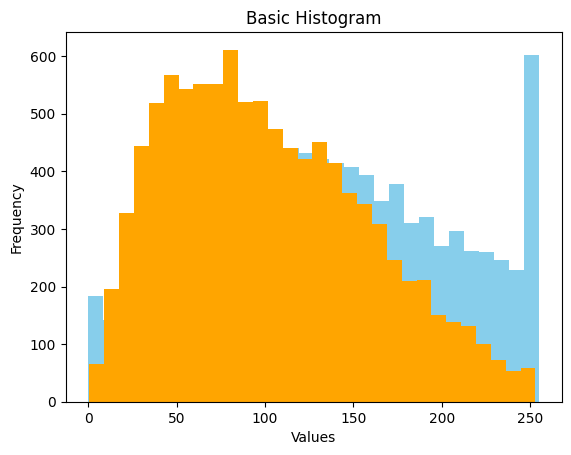

In [30]:
for i in range(1):
    temp1=real_images_mean[i]
    temp2=fake_images_mean[i]
    plt.hist(x=temp1, bins=30, color='skyblue')
    plt.hist(x=temp2, bins=30, color='orange')
    
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title('Basic Histogram')
    plt.show()
fake_images_mean = np.transpose(fake_images_mean)
real_images_mean = np.transpose(real_images_mean)
fake_images_var = np.transpose(fake_images_var)
real_images_var = np.transpose(real_images_var)
features_m = np.vstack((fake_images_mean, real_images_mean))
features_v = np.vstack((fake_images_var, real_images_var))
labels = np.concatenate((fake_labels, real_labels))

In [31]:

def feature_vec(mean, var):
    a=[]
    for i,j in zip(mean, var):
        b=[]
        for k,l in zip(i,j):
            b.append(k)
            b.append(l)
        a.append(b)
    return a

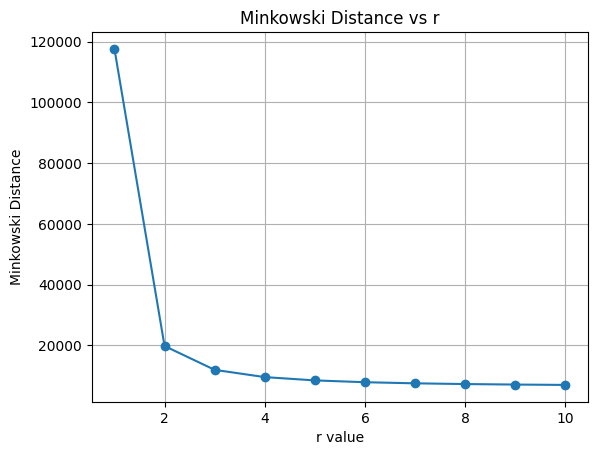

In [32]:

real_feat_vec = feature_vec(real_images_mean, real_images_var)
fake_feat_vec = feature_vec(fake_images_mean, fake_images_var)

r_values = range(1, 11)
distances = [minkowski(real_feat_vec[0], fake_feat_vec[0], r) for r in r_values]

plt.plot(r_values, distances, marker='o')
plt.xlabel('r value')
plt.ylabel('Minkowski Distance')
plt.title('Minkowski Distance vs r')
plt.grid(True)
plt.show()

In [33]:
X_train, X_test, Y_train, Y_test = train_test_split(features_m, labels, test_size=0.2, random_state=32)

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, Y_train)

accuracy = knn.score(X_test, Y_test)
print("Accuracy:", accuracy)

training_accuracy = knn.score(X_train, Y_train)
print(f"Training Accuracy: {training_accuracy}")
predictions = knn.predict(X_test[:20])
actual_labels = Y_test[:20]

# for i in range(len(predictions)):
#     print(f"Predicted: {predictions[i]}\tActual: {actual_labels[i]}")   

predicted_vs_actual = pd.DataFrame({"Actual": actual_labels, "Predicted": predictions})
predicted_vs_actual

Accuracy: 0.6665
Training Accuracy: 0.8306875


,Actual,Predicted
0,1,1
1,1,0
2,1,1
3,1,1
4,1,0
5,1,1
6,1,1
7,1,1
8,0,0
9,0,0


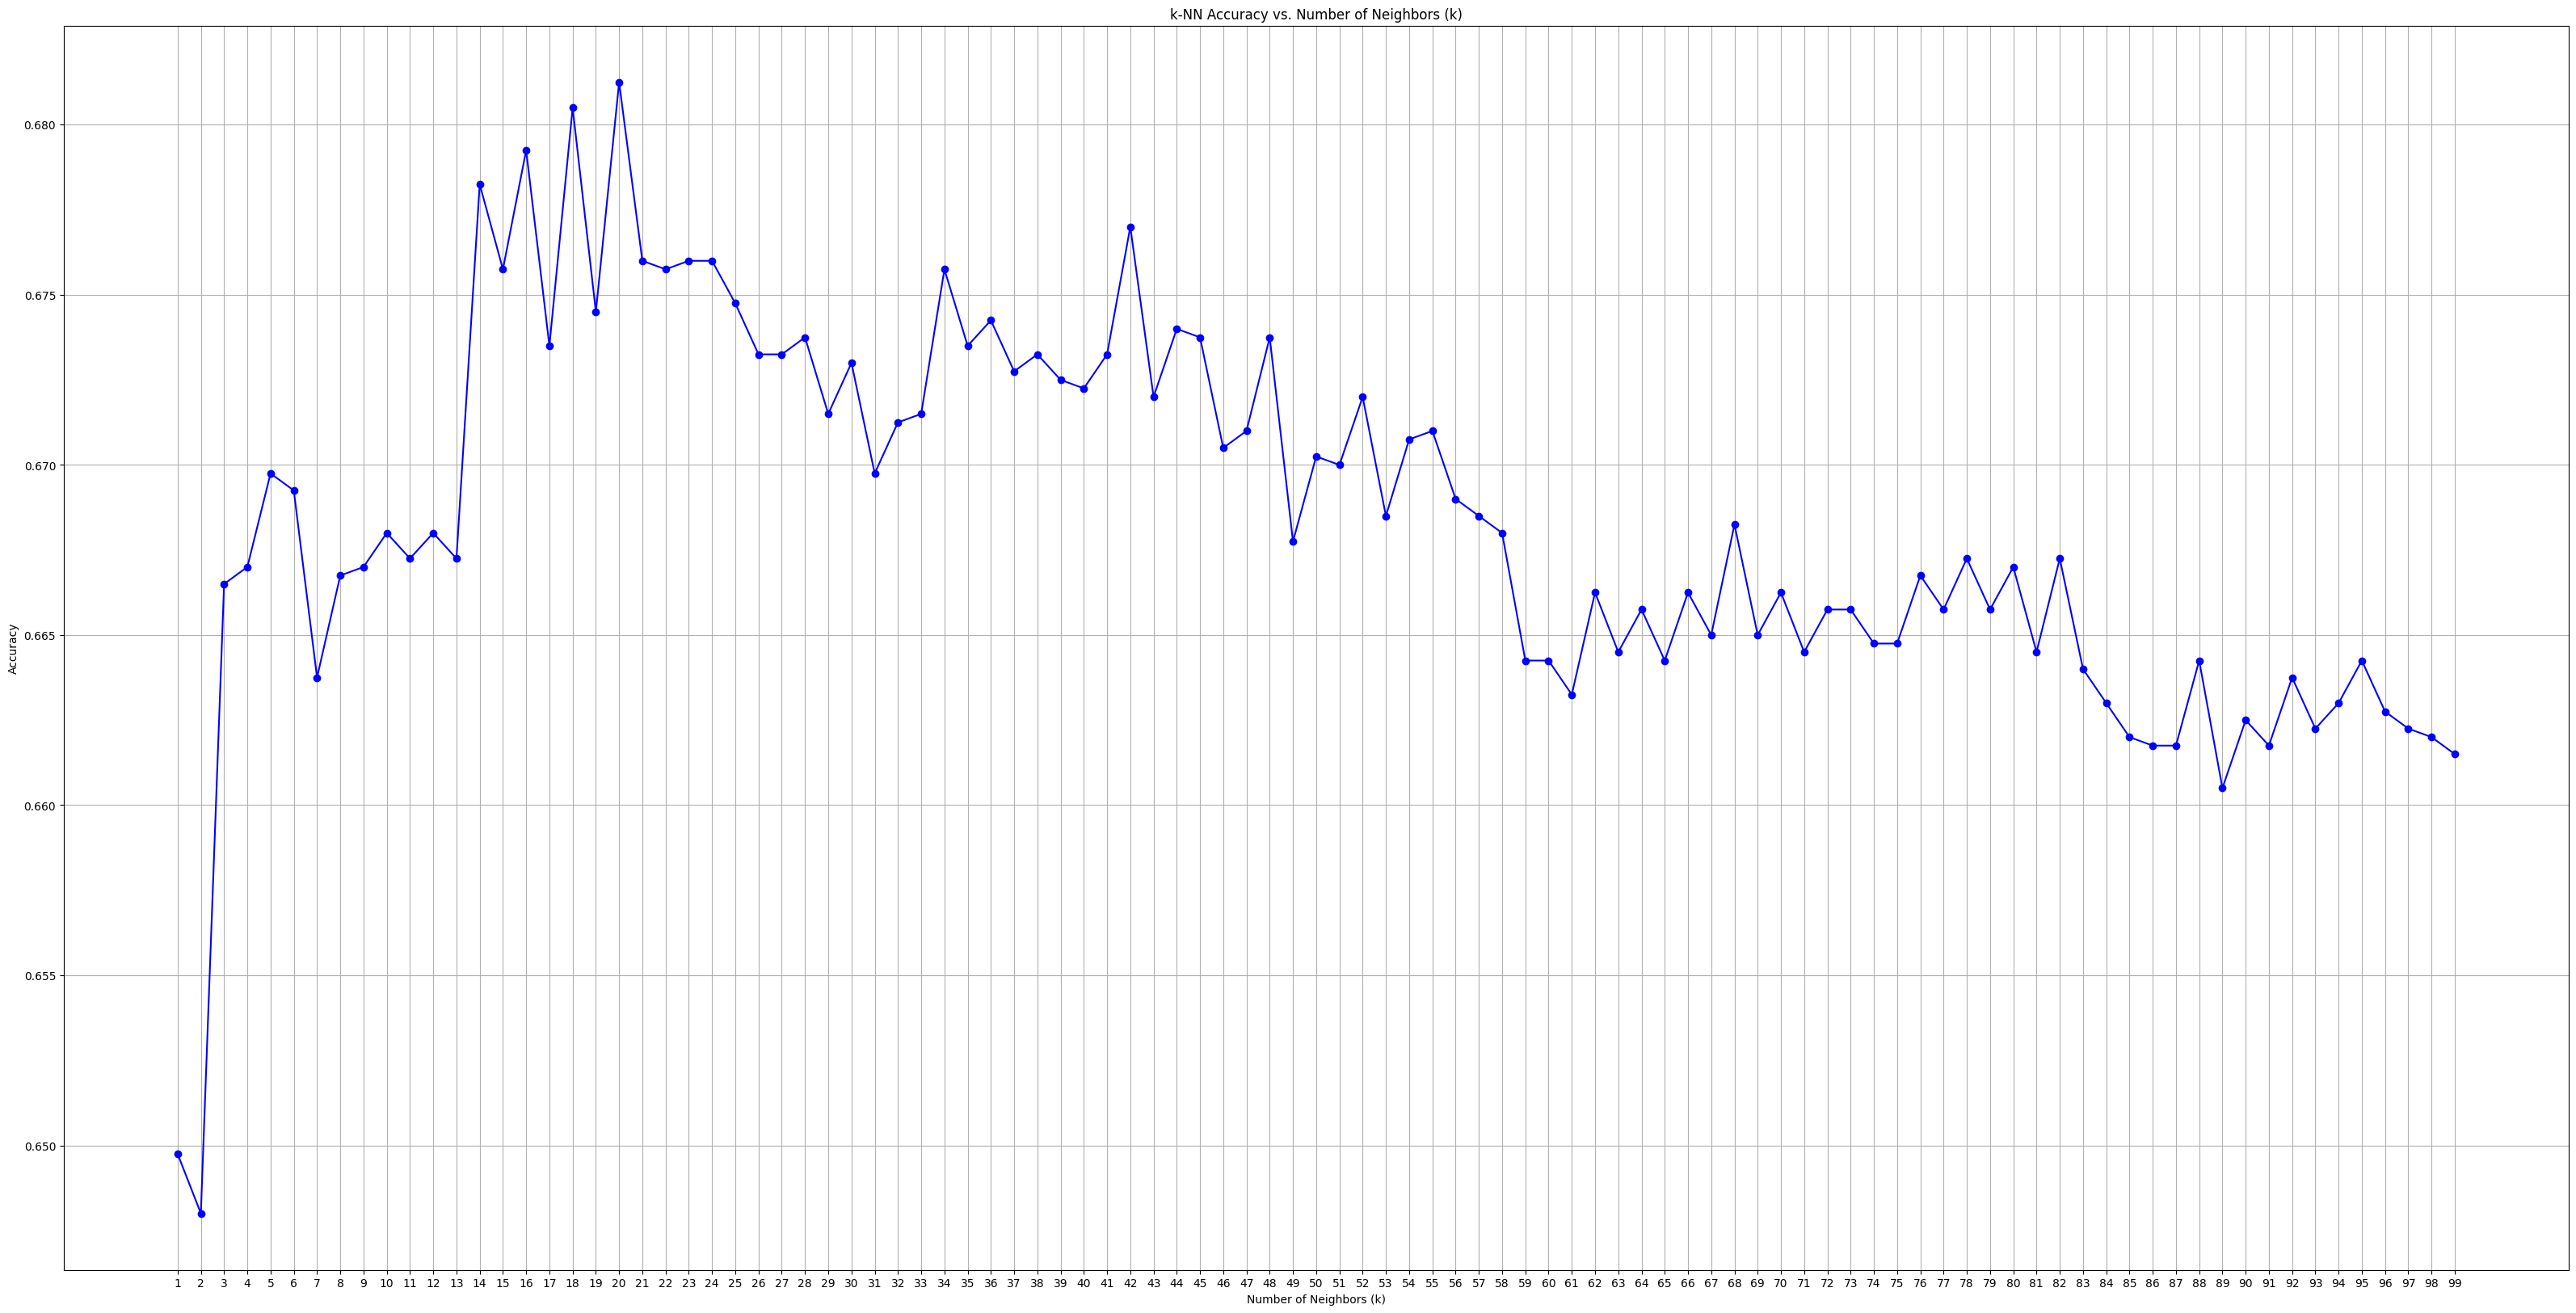

,K-Value,Accuracy
1,1,0.64975
2,2,0.64800
3,3,0.66650
4,4,0.66700
5,5,0.66975
...,...,...
95,95,0.66425
96,96,0.66275
97,97,0.66225
98,98,0.66200


In [34]:

k_values = range(1, 100)
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, Y_train)
    Y_pred = knn.predict(X_test)
    accuracy = accuracy_score(Y_test, Y_pred)
    accuracies.append(accuracy)
    Y_pred_train = knn.predict(X_train)
    training_accuracy = accuracy_score(Y_train,Y_pred_train)
    # print(f"Accuracy for k={k}: {accuracy}")  
            
accuracies_df = pd.DataFrame({"K-Value":k_values,"Accuracy": accuracies},index=k_values)


plt.figure(figsize=(40,20))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='b')
plt.title('k-NN Accuracy vs. Number of Neighbors (k)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.xticks(k_values)

plt.grid(True)
plt.show()

accuracies_df  

In [35]:

conf_mat = confusion_matrix(Y_test,Y_pred)
precision = precision_score(Y_test,Y_pred)
recall = recall_score(Y_test,Y_pred)
f_score = f1_score(Y_test,Y_pred)

print(f"Confusion Matrix:\n{conf_mat}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f_score}")

Confusion Matrix:
[[1346  671]
 [ 683 1300]]
Precision: 0.6595636732623034
Recall: 0.6555723651033787
F1 Score: 0.6575619625695498


In [ ]:
# conf_mat_train = confusion_matrix(y_train, y_pred)
conf_mat_train = ConfusionMatrixDisplay(Y_train,Y_pred_train,labels[0,1])
precision_train = precision_score(Y_train, Y_pred)
recall_train = recall_score(Y_train, Y_pred_train)
f_score_train = f1_score(Y_train, Y_pred_train)

print("Training Confusion Matrix:\n", conf_mat_train)
print("Training Precision:", precision_train)
print("Training Recall:", recall_train)
print("Training F1 Score:", f_score_train)